In [2]:
import os
import sys
WORKING_DIR = os.path.dirname(os.path.abspath('./'))
print(WORKING_DIR)
sys.path.append(WORKING_DIR)

/Users/lorenz/Repos/study_entity_linking_new


In [3]:
# import from csv file
import pandas as pd
import json

df = pd.read_json("../dataset/queries_combined_sample.json")

In [ ]:
# add 40 of the generated queries to the queries.json file
# original_queries = pd.read_json('../dataset/queries_sample.json')
    
# queries = pd.read_csv('../dataset/generated_queries.csv')

# queries = pd.concat([queries, original_queries])

# queries = queries.drop(columns=['Seen', 'Notes'])

# queries = queries.sample(200)
    
# # save to json file
# queries.to_json('../dataset/queries.json', orient='records')

In [ ]:
# current_value = 'reaktionszeit'

# # Initialize an empty list to store the values
# bildschirmgroesse_values = []

# # Iterate over each item in the series
# for item in entities:
#     # Check if 'bildschirmgroesse' is a key in the dictionary
#     if current_value in item:
#         # Extend the list with the values of 'bildschirmgroesse' if value is not already in the list
#         bildschirmgroesse_values.extend(item[current_value])

# # Construct the JSON structure
# json_structure = {
#     "type": "object",
#     "description": f"{current_value.capitalize()} des gewünschten Produkts.",
#     "properties": {
#         "values": {
#             "type": "array",
#             "description": f"{current_value.capitalize()} die genannt wurden",
#             "items": {
#                 "type": "string",
#                 "enum": list(set(bildschirmgroesse_values)),
#             },
#         },
#         "notSpecified": {
#             "type": "boolean",
#             "description": f"True wenn im Gespräch kein Wert für {current_value.capitalize()} nicht genannt wurde, sonst False",
#         },
#         "noSpecificUserPreference": {
#             "type": "boolean",
#             "description": f"True wenn der Kunde keine bestimmte Präferenz für {current_value.capitalize()} hat, sonst False",
#         },
#     },
# }

# # Print the JSON structure
# print(json.dumps(json_structure, indent=4, ensure_ascii=False))


In [6]:
import os
import sys
WORKING_DIR = os.path.dirname(os.path.abspath('./'))
print(WORKING_DIR)
sys.path.append(WORKING_DIR)

# load_and_export.py
import os

from app.entity_linking import EntityLinking
from app.foundation_models.chat_openai import AIModelType
from app.schema import json_schema

current_model = AIModelType.LLAMA_3_70B

async def recognize_filters(message: str):
    # generate function call schema
    schema = json_schema
    
    # gemerate function calling schema
    llm_module = EntityLinking(schema=schema,model=current_model)
    
    if current_model == AIModelType.MISTRAL_LARGE or current_model == AIModelType.MISTRAL_MIXTRAL_8x22B or current_model == AIModelType.MISTRAL_SMALL:
        filter_generator_output = llm_module.generate_sync(conversation=message)
    else:
        filter_generator_output = await llm_module.generate_async(conversation=message)
        
    
    recognized_filters = []
    
    for filter in filter_generator_output:
        filtered_dict = {k: v for k, v in filter.model_dump().items() if v is not None and v}

        recognized_filters.append(filtered_dict)

    return (
        filter_generator_output,
        recognized_filters,
    )
    
# test the function
message = "Fernseher mit 8K oder 4k unter 1500 Euro"
filter_generator_output, recognized_filters = await recognize_filters(message)
print(filter_generator_output)
print(recognized_filters)
print(json.dumps(recognized_filters, indent=4, ensure_ascii=False))

# save to json file
with open('./temp.json', 'w') as f:
    json.dump(recognized_filters, f, indent=4, ensure_ascii=False)

/Users/lorenz/Repos/study_entity_linking_new
attr Kategorie
filter_data Fernseher
type <class 'str'>
attr Aufloesung
filter_data ['Ultra-HD-8K', 'Ultra-HD-4K']
type <class 'list'>
attr Preis
filter_data {'max': 1500, 'noSpecificUserPreference': True}
type <class 'dict'>
[FilterGeneratorOutput(id='Kategorie', values=['Fernseher'], minimum=None, maximum=None), FilterGeneratorOutput(id='Aufloesung', values=['Ultra-HD-8K', 'Ultra-HD-4K'], minimum=None, maximum=None), FilterGeneratorOutput(id='Preis', values=[], minimum=None, maximum=1500)]
[{'id': 'Kategorie', 'values': ['Fernseher']}, {'id': 'Aufloesung', 'values': ['Ultra-HD-8K', 'Ultra-HD-4K']}, {'id': 'Preis', 'maximum': 1500}]
[
    {
        "id": "Kategorie",
        "values": [
            "Fernseher"
        ]
    },
    {
        "id": "Aufloesung",
        "values": [
            "Ultra-HD-8K",
            "Ultra-HD-4K"
        ]
    },
    {
        "id": "Preis",
        "maximum": 1500
    }
]


In [11]:
# iterate over rows with iterrows()
import asyncio
import json

tasks = []

for index, row in df.iterrows():
    predicted_entities = row[4]

    if predicted_entities is not None and type(predicted_entities) == str:
        print("Already predicted entities")
        continue

    query = row[1]
    actual_category = row[2]
    print(actual_category)
    print(query)

    async def recognize_and_return_index(
        index, message: str
    ):
        (filter_generator_output, recognized_filters) = (
            await recognize_filters(
                message=message,
            )
        )
        
        print(recognized_filters)

        df.at[index, "Prediction"] = json.dumps(recognized_filters)
        return index

    print(index)
    
    try:
        await recognize_and_return_index(
        index=index,
        message=query,
    )
    except Exception as e:
        print(e)
        continue

    # wait to avoid rate limiting
    await asyncio.sleep(5)

 
    # write to csv
    df.to_json(f"prediction_{current_model}_v1.json", index=False, orient="records")


print(len(tasks))

/var/folders/lj/dk78kkr16dxcgq62lqvfy19c0000gn/T/ipykernel_16699/600850859.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predicted_entities = row[4]
/var/folders/lj/dk78kkr16dxcgq62lqvfy19c0000gn/T/ipykernel_16699/600850859.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = row[1]
/var/folders/lj/dk78kkr16dxcgq62lqvfy19c0000gn/T/ipykernel_16699/600850859.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_cat

Already predicted entities
Already predicted entities
Already predicted entities
Already predicted entities
Already predicted entities
Other
tv lowboard
5
attr Kategorie
filter_data Fernseher
type <class 'str'>
attr Art
filter_data ['Lowboard']
type <class 'list'>
[{'id': 'Kategorie', 'values': ['Fernseher']}, {'id': 'Art', 'values': ['Lowboard']}]
Other
cd laufwerk für laptop
6
attr Kategorie
filter_data Laptops
type <class 'str'>
attr Ausstattung
filter_data ['cd laufwerk']
type <class 'list'>
[{'id': 'Kategorie', 'values': ['Laptops']}, {'id': 'Ausstattung', 'values': ['cd laufwerk']}]
Laptops
chromebook
7
attr Kategorie
filter_data Laptops
type <class 'str'>
attr Modellreihe
filter_data Chromebook
type <class 'str'>
[{'id': 'Kategorie', 'values': ['Laptops']}, {'id': 'Modellreihe', 'values': ['Chromebook']}]
Computer
computer pc
8
attr Kategorie
filter_data Computer
type <class 'str'>
[{'id': 'Kategorie', 'values': ['Computer']}]
Fernseher
fernseher 65 zoll lg triple tuner
9
attr K

In [12]:
def normalize_string(s):
    if type(s) == int:
        return str(s)
    """Normalize a string by removing spaces, converting to lowercase, and replacing dashes."""
    return s.replace(' ', '').replace('-', '').replace('/','').lower()

mapping = {
    "ultrahd4k": "ultrahd",
    "größerals84zoll": 'gr\\u00f6\\u00dferals84zoll',
    "größerals19zoll": 'gr\\u00f6\\u00dferals19zoll',
    "144hz": "144hz",
}

speicherkapazitaet_mapping = {
    "256" : "256gb",
    "512" : "512gb",
    "1024" : "1024gb",
    "128" : "128gb",
    "64" : "64gb",
}

bildwiederholungsfrequenz_mapping = {
    "60" : "60hz",
    "120" : "120hz",
    "144" : "144hz",
    "165": "165hz",
    "240" : "240hz",
}


def split_entities_in_separated_entities(filter) -> list[tuple]:
    separated_entities = []
    for (key,values) in filter.items():
        for value in values:
            normalized_value = normalize_string(value)
            mapped_value = mapping.get(normalized_value, normalized_value)
            if key == "speicherkapazitaet":
                mapped_value = speicherkapazitaet_mapping.get(normalized_value, normalized_value)
            if key == "bildwiederholungsfrequenz":
                mapped_value = bildwiederholungsfrequenz_mapping.get(normalized_value, normalized_value)
            if key == "preis":
                mapped_value = value
                print("preis", value)
            separated_entities.append((key, mapped_value))
            
    return separated_entities

def calculate_tp_fn_fp(actual: list[tuple], predicted: list[tuple]):
    """
    Calculates the true positives (tp), false negatives (fn), and false positives (fp) 
    for a given set of actual and predicted entities.

    Args:
        actual (list[tuple]): The list of actual entities.
        predicted (list[tuple]): The list of predicted entities.

    Returns:
        tuple: A tuple containing the counts of tp, fn, fp, and tn.
    """

    tp = 0
    fp = 0
    fn = 0
    tn = 0

    fp_entities = []
    fn_entities = []

    if len(actual) == 0 and len(predicted) == 0:
        tn = 1
        return tp, fn, fp, tn, fp_entities,fn_entities


    for entity in actual:
        if entity in predicted:
            tp += 1
        else:
            fn += 1
            fn_entities.append((actual, entity))

    for entity in predicted:
        if entity not in actual:
            fp += 1
            fp_entities.append((actual, entity))

    return tp, fn, fp, tn, fp_entities, fn_entities


def calculate_precision_recall_f1(tp, fn, fp):
    if tp + fp > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0

    if tp + fn > 0:
        recall = tp / (tp + fn)
    else:
        recall = 0

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0

    return precision, recall, f1

In [14]:
# import pandas as pd
import json
df = pd.read_json(f"prediction_LLAMA_3_70B_v1.json")

In [15]:

import math
import numpy as np

total_tp = 0
total_fn = 0
total_fp = 0
total_tn = 0

false_positives = []
false_negatives = []

for index, row in df.iterrows():
    query = row[1]
    print(query)
    print(row[3])
    actual_entities = json.loads(row[3])
    actual_category = row[2]

    if actual_category == "Other":
        continue

    predicted_entities = row[4]

    # check if predicted entities is nan
    if isinstance(predicted_entities, float) and math.isnan(predicted_entities):
        predicted_entities = []
    elif type(predicted_entities) == dict:
        continue
    elif predicted_entities is None:
        predicted_entities = []
    else:
        predicted_entities = json.loads(predicted_entities)

    # convert predicted entities to dict
    converted_predicted_entities = {}
    
    for entity in predicted_entities:
        if 'values' in entity:
            converted_predicted_entities.update({entity['id'].lower(): entity['values']})
        else:
            if 'maximum' in entity or 'minimum' in entity:
                converted_predicted_entities.update({entity['id'].lower(): [str(entity.get("minimum",0)),str(entity.get("maximum",0))]})


    # print("converted_predicted_entities",converted_predicted_entities)
    # process predicted entities
    predicted_entities = split_entities_in_separated_entities(converted_predicted_entities)
    actual_entities = split_entities_in_separated_entities(actual_entities)
    
    print("predicted_entities",predicted_entities)
    print("actual_entities",actual_entities)
    
    # add category tuple to actual entities
    actual_entities.append(("kategorie", normalize_string(actual_category)))
    
    
    (tp, fn, fp, tn, fp_entities,fn_entities) = calculate_tp_fn_fp(actual_entities, predicted_entities)
    total_tp += tp
    total_fn += fn
    total_fp += fp
    total_tn += tn

    if len(fp_entities) > 0:
        false_positives.append((query, fp_entities))

    if len(fn_entities) > 0:
        false_negatives.append((query, fn_entities))


# calculate precision, recall, and f1
precision, recall, f1 = calculate_precision_recall_f1(total_tp, total_fn, total_fp)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
print("total tn", total_tn)

    

macbook pro m2 15 zoll
{"marke":["Apple"],"prozessor":["M2"],"modellreihe":["MacBook Pro"],"bildschirmgroesse":["15 Zoll"]}
predicted_entities [('kategorie', 'laptops'), ('marke', 'apple'), ('bildschirmgroesse', '15zoll'), ('prozessor', 'm2'), ('modellreihe', 'macbookpro')]
actual_entities [('marke', 'apple'), ('prozessor', 'm2'), ('modellreihe', 'macbookpro'), ('bildschirmgroesse', '15zoll')]
Fernseher mit 8K unter 1500 Euro
{"aufloesung":["Ultra-HD-8K"],"preis":["0","1500"]}
preis 0
preis 1500
preis 0
preis 1500
predicted_entities [('kategorie', 'fernseher'), ('aufloesung', 'ultrahd8k'), ('preis', '0'), ('preis', '1500')]
actual_entities [('aufloesung', 'ultrahd8k'), ('preis', '0'), ('preis', '1500')]
monitor 32 zoll 4k
{"aufloesung":["Ultra-HD "],"bildschirmgroesse":["32 Zoll"]}
predicted_entities [('kategorie', 'monitor'), ('bildschirmgroesse', '32zoll'), ('aufloesung', 'ultrahd')]
actual_entities [('aufloesung', 'ultrahd'), ('bildschirmgroesse', '32zoll')]
notebook 15 zoll betrieb

/var/folders/lj/dk78kkr16dxcgq62lqvfy19c0000gn/T/ipykernel_16699/2669958350.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  query = row[1]
/var/folders/lj/dk78kkr16dxcgq62lqvfy19c0000gn/T/ipykernel_16699/2669958350.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(row[3])
/var/folders/lj/dk78kkr16dxcgq62lqvfy19c0000gn/T/ipykernel_16699/2669958350.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_entities = js

In [16]:
# write false positives to file
with open('false_positives.txt', 'w') as f:
    for fp in false_positives:
        f.write(f"{fp}\n")

In [17]:
# write false negatives to file
with open('false_negatives.txt', 'w') as f:
    for fn in false_negatives:
        f.write(f"{fn}\n")

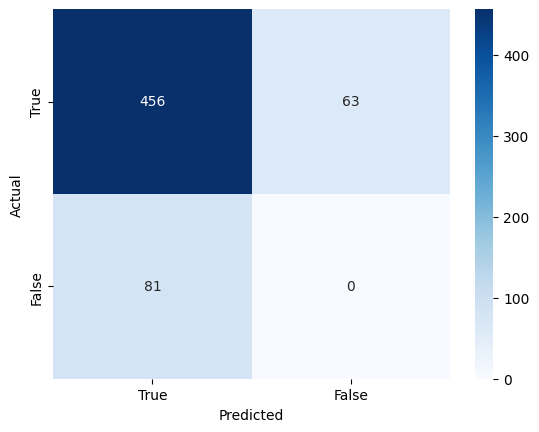

In [18]:
# visualize the results in a confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# create confusion matrix
conf_matrix = np.array([[total_tp, total_fn], [total_fp, total_tn]])

# create heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'False'], yticklabels=['True', 'False'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


We have lots of false negatives, as the model does not have all filter ids in schema for Function Call Model. We use custom filter ids for the experiment, to give them a fair chance.

In [ ]:
def process_entities(x):
    if isinstance(x, float) and math.isnan(x):
        x = []
    else:
        x = json.loads(x)

    return {entity["id"]: entity["values"] for entity in x}


# Detect all filters that are never recognized
actual_entities = df["Entities"].apply(json.loads).explode().dropna().unique()

predicted_entities = df["Recognized_Filters_Prediction"].apply(process_entities)
predicted_entities = predicted_entities.explode().dropna().unique()

never_recognized = [entity for entity in actual_entities if entity not in predicted_entities]
print(never_recognized)

In [ ]:
grouped = df.groupby("Category")
unique_entities = grouped['Entities'].apply(lambda x: x.apply(json.loads).explode().dropna().unique())
    
# store to json
unique_entities.to_json('filters_per_category.json')